# How to use background knowledge  

Often we have no information about the parameters we want to infer. 
Then the methods from classical statistics are the most appropriate.
However, as soon as we want to pose some restrictions on the parameters, we quickly run into trouble.
It is impossible to incorporate background knowledge into frequentistic methods and this will lead to inconsistencies in what we infer and what we known.
The proper way out is to use Bayesian methods and encode background knowledge into a prior distribution. 
We demonstrate this for the coinflipping problem as it does not hide the underlying issues into a clutter of technical details.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from statsmodels.stats.proportion import proportion_confint

from tqdm import tnrange
from plotnine import *
from plotnine import options

# Local imports
from common import *
from convenience import *

## I. Inevitable contradictions with background knowledge

Let us consider the following task as an illustrative example. 
Your task is to estimate the bias of a coin $p=\Pr[B_i=1]$ under the assumption that $p\in[0.1, 0.2]$.
This is a bit difficult to imagine for an actual physical coin but there are plenty of processes that are so asymmetric, such as the labelling error of a good classifier.
What should we do if we observe $B_1=\ldots=B_N=1$? 
The confidence interval $[p_0,p_1]$ output by standard statistical methods is clearly wrong. 


In [2]:
proportion_confint(count=10, nobs=20, alpha=0.05)

(0.28086936485585456, 0.7191306351441454)

Moreover, the same problem occurs with other observations, though in a less severe manner:

In [3]:
df = (DataFrame({'k': list(range(0,21))})
      .assign(ci = lambda df: df['k'].apply(proportion_confint, nobs=20, alpha=0.05))
      .assign(q0 = lambda df: df['ci'].apply(lambda x: x[0]), q1 = lambda df: df['ci'].apply(lambda x: x[1]))
      .drop(columns=['ci']))

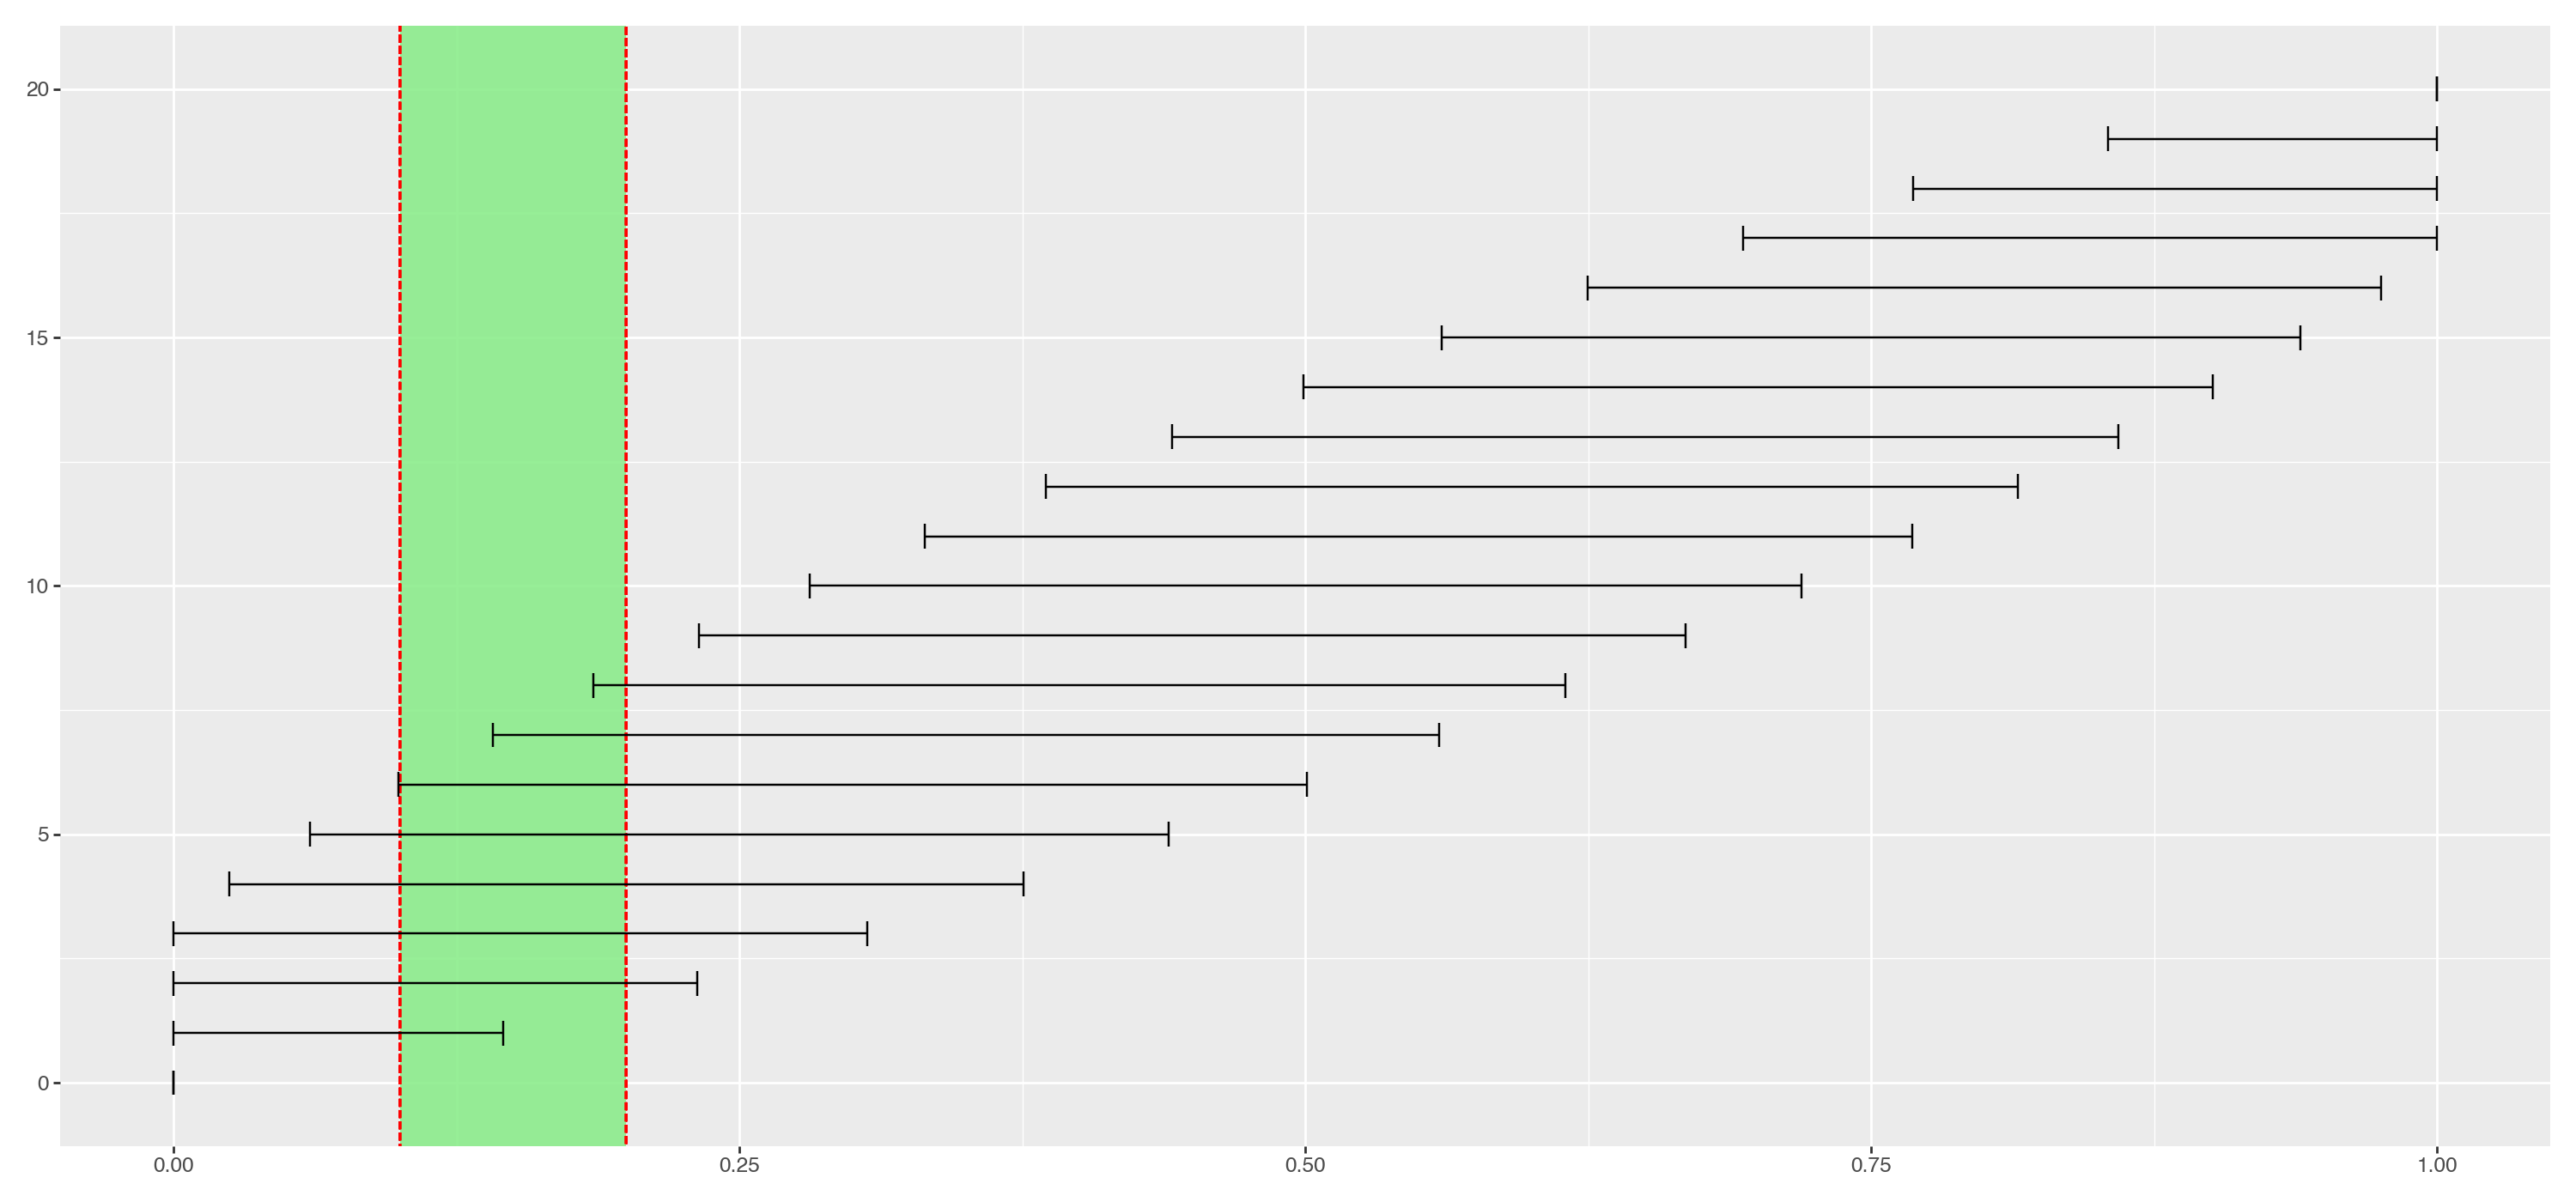

In [4]:
options.figure_size = (15, 7)
p = ggplot(df)
p = p + geom_rect(xmin=0.1, xmax=0.2, ymin=-5, ymax=100.0, fill = 'lightgreen', color = 'red', alpha =0.1, linetype='--')
p = p + geom_errorbarh(aes(xmin = 'q0', xmax = 'q1', y='k'))
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '') 
display(p)
# p.save('confidence_intervals_vs_background_knowledge.pdf', path='results', height=6, width=12, verbose=False)

## II. Belief update procedure for the coinflipping observations

To apply Bayes theorem, we need do define a data generation model and find a suitable distribution to model our beliefs about the values of the model parameters. 
The coinflipping outcome $k$ is determined only by the bias of the coin $p$ and the number of observations $n$ where the latter is a known value. 
Thus the posterior distribution for the parameter $p$ is given by the formula

\begin{align*}
\Pr[p|k]=\frac{\Pr[k|p]\Pr[p]}{\Pr[k]}\enspace,
\end{align*}

where the **likelihood** of the data is specified by the following binomial distribution:

\begin{align*}
\Pr[k|p]=\Pr[B_1+\ldots+B_n=k]=\binom{n}{k}p^k(1-p)^{n-k}\enspace.
\end{align*}

To go further, we need to fix the prior distribution. In the following, we consider two simplified cases.

## III. Uninformative prior with finite precision

In principle, the bias term in coinflipping can have any value from the range $[0,1]$.
However, values with inifinite precision are not practical and introduce integrals to posterior computations. Thus we make a simplifying assumption that the parameter $p\in\{0.000, 0.001, \ldots,0.999, 1.000\}$ and assign the same probability for every possible parameter value:

\begin{align*}
\Pr[p=0.000]=\ldots = \Pr[p=1.000]\enspace.
\end{align*}

Then we can compute the normalising term

\begin{align*}
\Pr[k]=\frac{1}{1001}\cdot\sum_{p=0.001}^{1.000}\binom{n}{k} p^k(1-p)^{n-k}
=\frac{1}{1001}\cdot\binom{n}{k}\cdot\sum_{p=0.001}^{1.000} p^k(1-p)^{n-k}
\end{align*}

and substitute it into the posterior formula. After removing the reoccurring constants in the denominator and numerator, we get

\begin{align*}
\Pr[p|k]=\frac{p^k(1-p)^{n-k}}{\sum_{p=0.001}^{1.000} p^k(1-p)^{n-k}}\enspace.
\end{align*}

### Belief update procedure

In [5]:
def uninformed_belief_update(k: int, n: int, m: int=1000) -> DataFrame:
    """
    Returns the data frame containing prior and posterior beliefs for coin bias
    
    k – the number of heads
    n – the number of throws
    m – the number of parameter values on the unit range [0,1] 
    """
    
    return (DataFrame({'p': np.linspace(0, 1, num = m + 1, endpoint=True)})
            .assign(prior = lambda df: 1/len(df))
            .assign(likelihood = lambda df: stats.binom.pmf(k=k, n=n, p=df['p']))
            .assign(posterior = lambda df: df['likelihood']/df['likelihood'].sum()))

In [6]:
display(uninformed_belief_update(10, 20, 10))

,p,prior,likelihood,posterior
0,0.0,0.090909,0.000000,0.000000
1,0.1,0.090909,0.000006,0.000014
2,0.2,0.090909,0.002031,0.004266
3,0.3,0.090909,0.030817,0.064716
4,0.4,0.090909,0.117142,0.245997
5,0.5,0.090909,0.176197,0.370014
6,0.6,0.090909,0.117142,0.245997
7,0.7,0.090909,0.030817,0.064716
8,0.8,0.090909,0.002031,0.004266
9,0.9,0.090909,0.000006,0.000014


### Credibility intervals

In [7]:
def credibility_interval(df: DataFrame, alpha:float=0.05, interval_type:str='two-sided') -> DataFrame:
    """
    Given a data frame with a posterior column, returns endpoints of posterior intervals.
    
    alpha    – significance level
    interval – left, right or two-sided
    
    Returns a data frame with two rows where the first row corresponds to the start and the 
    last row corresponds to the end of the posterior interval.
    
    The data frame must be sorted according to the parameter value, otherwise the result is nonsensical
    """
    
    if interval_type == 'two-sided':
        return (df.loc[(df['posterior'].cumsum() > 0.5 * alpha) & 
                       (df.loc[::-1,'posterior'].cumsum()[::-1] > 0.5 * alpha)]
                .iloc[[0,-1]].reset_index(drop=True))
    elif interval_type == 'right':
        return (df.loc[df['posterior'].cumsum() > alpha]
                .iloc[[0,-1]].reset_index(drop=True))
    elif interval_type == 'left':
        return (df.loc[(df.loc[::-1,'posterior'].cumsum()[::-1] > alpha)]
                .iloc[[0,-1]].reset_index(drop=True))
    
    raise NotImplementedError()           

In [8]:
df = uninformed_belief_update(10, 20, 100)
mdisplay([
    credibility_interval(df, interval_type='left'),
    credibility_interval(df, interval_type='two-sided'),
    credibility_interval(df, interval_type='right')], ['left', 'two-sided', 'right'])

left two-sided right 
 
 
 p 
 prior 
 likelihood 
 posterior 
 
 
 
 
 0.00 
 0.009901 
 0.000000 
 0.000000 
 
 
 0.67 
 0.009901 
 0.051581 
 0.010832 
 
 
 
 
 
 p 
 prior 
 likelihood 
 posterior 
 
 
 
 
 0.3 
 0.009901 
 0.030817 
 0.006472 
 
 
 0.7 
 0.009901 
 0.030817 
 0.006472 
 
 
 
 
 
 p 
 prior 
 likelihood 
 posterior 
 
 
 
 
 0.33 
 0.009901 
 0.051581 
 0.010832 
 
 
 1.00 
 0.009901 
 0.000000 
 0.000000

### Visualisation

In [9]:
m = 1000

# Compute posterior and posterior intervals
df = uninformed_belief_update(10, 20, m)
ci = credibility_interval(df)

# Reshape the data to get color labels.
# Shift the data to center the parameter values within each step
df = (DataFrame(df.set_index('p').stack(),columns = ['value'])
      .reset_index()
      .rename(columns={'level_1': 'function'})
      .assign(p1 = lambda df: df['p']-0.5/m))

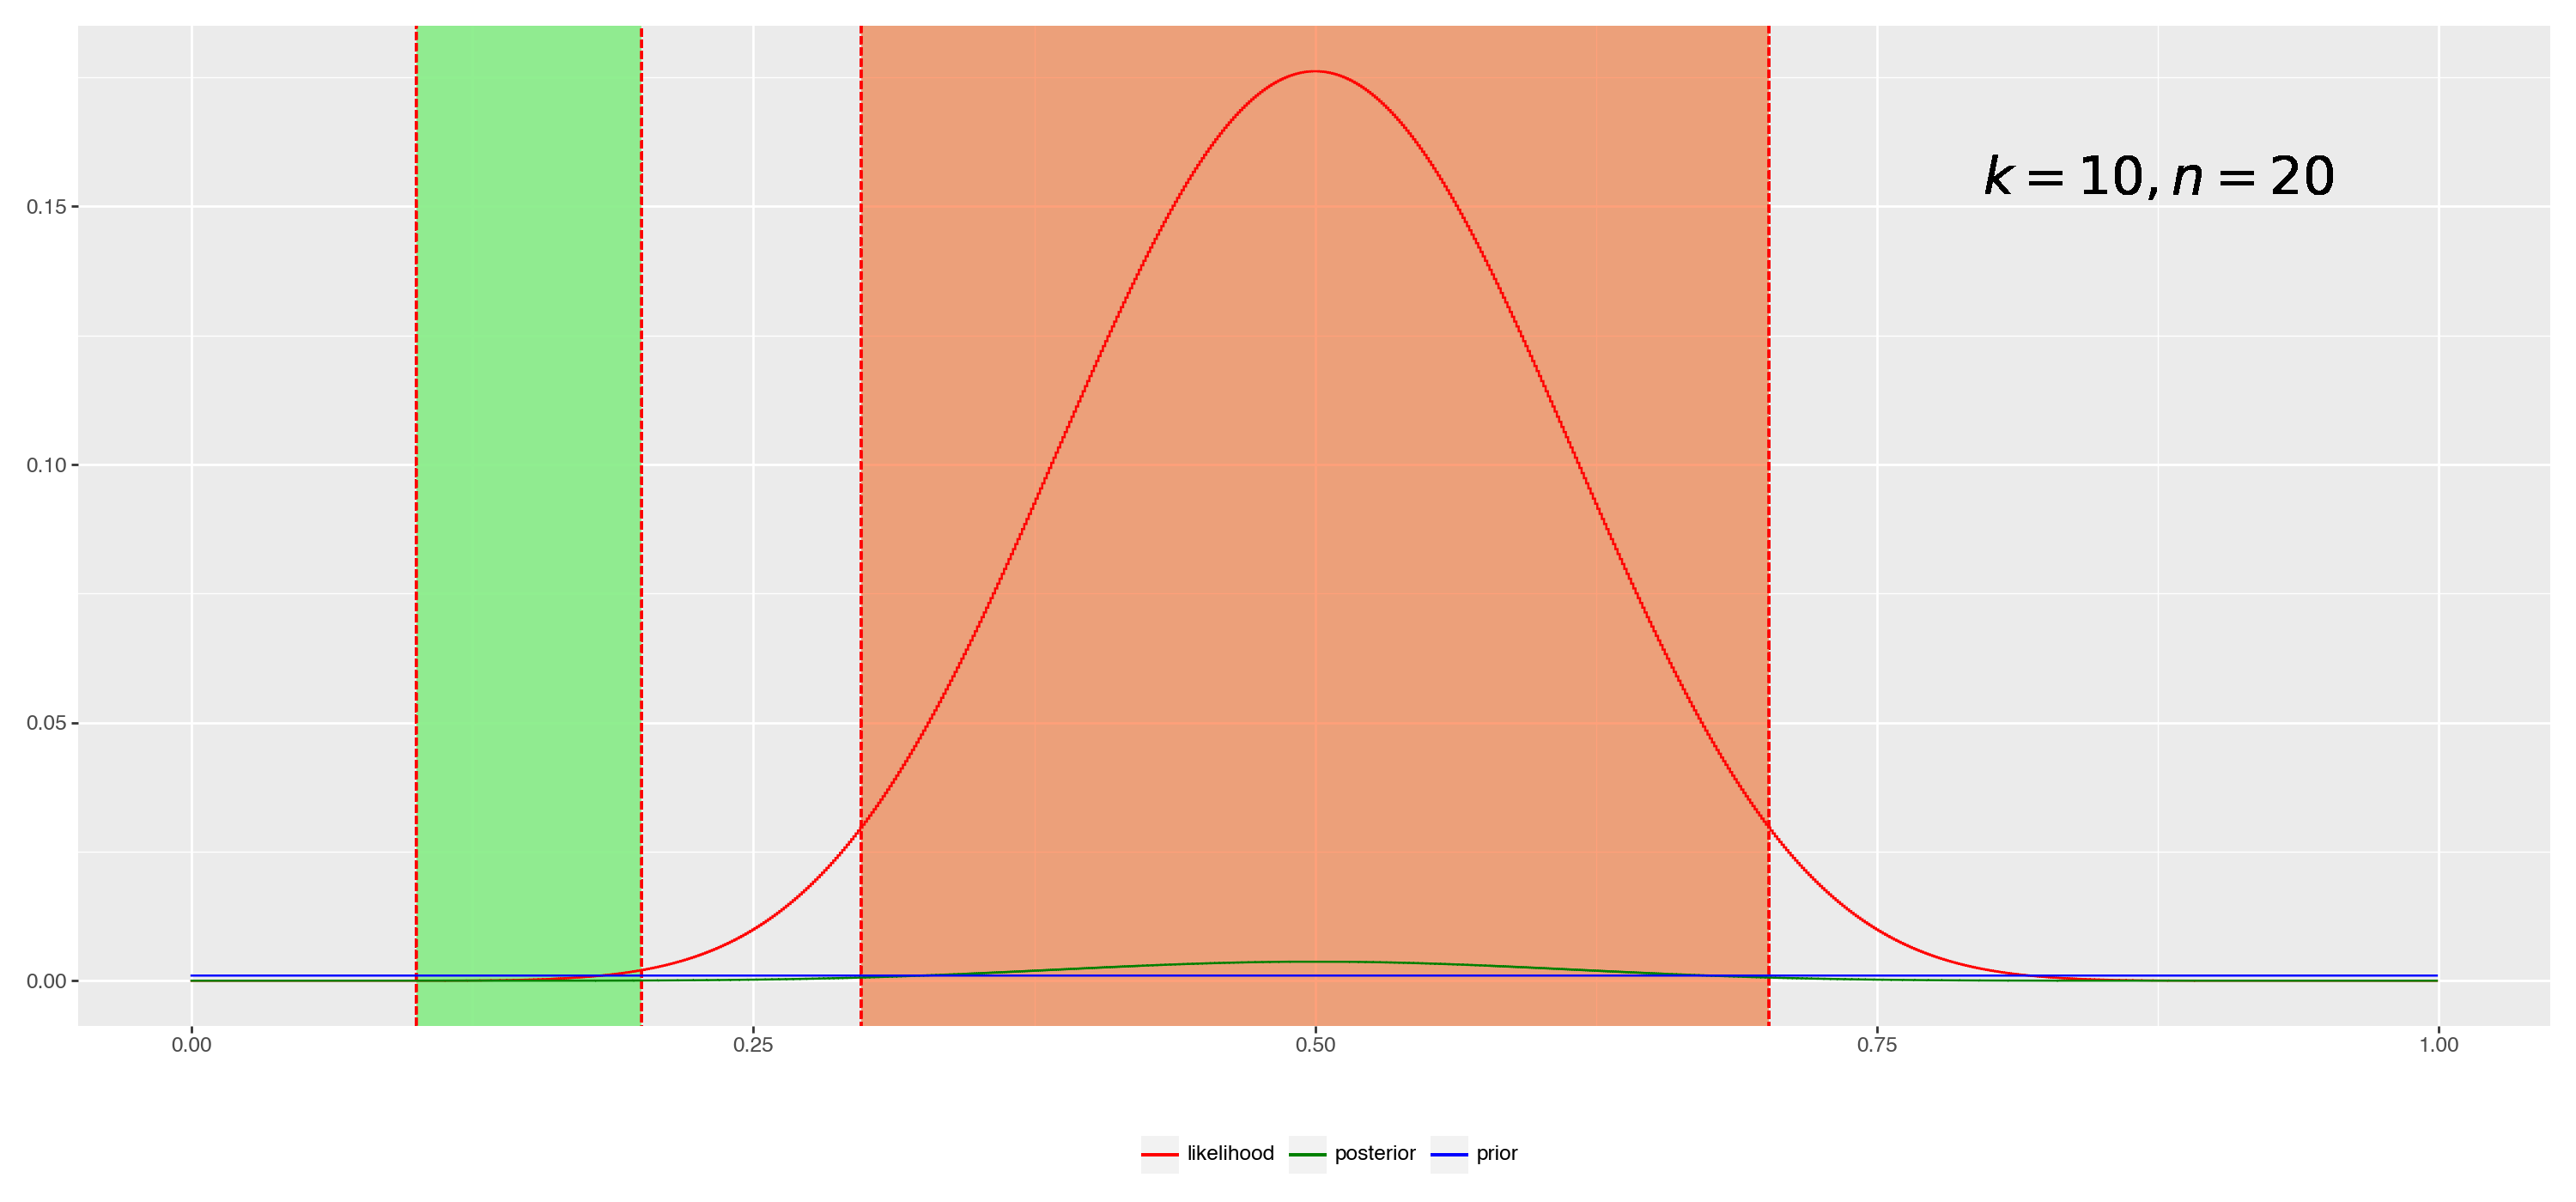

In [10]:
options.figure_size = (15, 7)
p = ggplot(df)
p = p + geom_rect(xmin=0.1, xmax=0.2, ymin=-5, ymax=5.0, 
                  fill = 'lightgreen', color = 'red', alpha =0.1, linetype='--')
p = p + geom_rect(xmin = ci.loc[0, 'p'], xmax = ci.loc[1,'p'], ymin=-0.5, ymax=5.0, 
                  fill = 'lightsalmon', color = 'red', alpha =0.05, linetype='--')
p = p + geom_step(aes(x = 'p1', y = 'value', color = 'function'))
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
p = p + theme(legend_position="bottom")
p = p + scale_color_manual(name = ' ', values = ['red', 'green', 'blue'])
p = p + geom_text(x=0.875, y=0.155, label =r'$k=10, n=20$', size=22)
display(p)
# p.save('uninformed_posterior.pdf', path='results', height=6, width=12, verbose=False)

## IV.  Informed prior with finite precision

In principle, the bias term in coinflipping can have any value from the range $[0,1]$.
However, values with inifinite precision are not practical and introduce integrals to posterior computations. 
As the coin bias must be in the range $[0.1, 0.2]$, we make a simplified assumption that the parameter $p\in\{0.100, 0.101, \ldots,0.199, 0.200\}$ and assign the same probability for every possible parameter value:

\begin{align*}
\Pr[p=0.100]=\ldots = \Pr[p=0.200]\enspace.
\end{align*}

Then we can compute the normalising term

\begin{align*}
\Pr[k]=\frac{1}{101}\cdot\sum_{p=0.100}^{0.200}\binom{n}{k} p^k(1-p)^{n-k}
=\frac{1}{101}\cdot\binom{n}{k}\cdot\sum_{p=0.100}^{0.200} p^k(1-p)^{n-k}
\end{align*}

and substitute it into the posterior formula. After removing the reoccurring constants in the denominator and numerator, we get

\begin{align*}
\Pr[p|k]=\frac{p^k(1-p)^{n-k}}{\sum_{p=0.100}^{0.200} p^k(1-p)^{n-k}}\quad\text{for } p\in[0.1,0.2]\enspace.
\end{align*}

In [11]:
def informed_belief_update(k: int, n: int, m: int=1000) -> DataFrame:
    """
    Returns the data frame containing prior and posterior beliefs for coin bias
    
    k - the number of heads
    n - the number of throws
    m - the number of parameter values on the range [0.1,0.2] 
    """
    
    return (DataFrame({'p': np.linspace(0.1, 0.2, num = m + 1, endpoint=True)})
            .assign(prior = lambda df: 1/len(df))
            .assign(likelihood = lambda df: stats.binom.pmf(k=k, n=n, p=df['p']))
            .assign(posterior = lambda df: df['likelihood']/df['likelihood'].sum()))

In [12]:
display(informed_belief_update(10, 20, 10))

,p,prior,likelihood,posterior
0,0.10,0.090909,0.000006,0.001132
1,0.11,0.090909,0.000015,0.002625
2,0.12,0.090909,0.000032,0.005596
3,0.13,0.090909,0.000063,0.011114
4,0.14,0.090909,0.000118,0.020774
5,0.15,0.090909,0.000210,0.036843
6,0.16,0.090909,0.000355,0.062409
7,0.17,0.090909,0.000578,0.101514
8,0.18,0.090909,0.000907,0.159265
9,0.19,0.090909,0.001377,0.241903


### Visualisation

In [13]:
m = 100

# Compute posterior and posterior intervals
df = informed_belief_update(10, 20, m)
ci = credibility_interval(df)

# Reshape the data to get color labels.
# Shift the data to center the parameter values within each step
df = (DataFrame(df.set_index('p').stack(),columns = ['value'])
      .reset_index()
      .rename(columns={'level_1': 'function'})
      .assign(p1 = lambda df: df['p']-0.05/m))

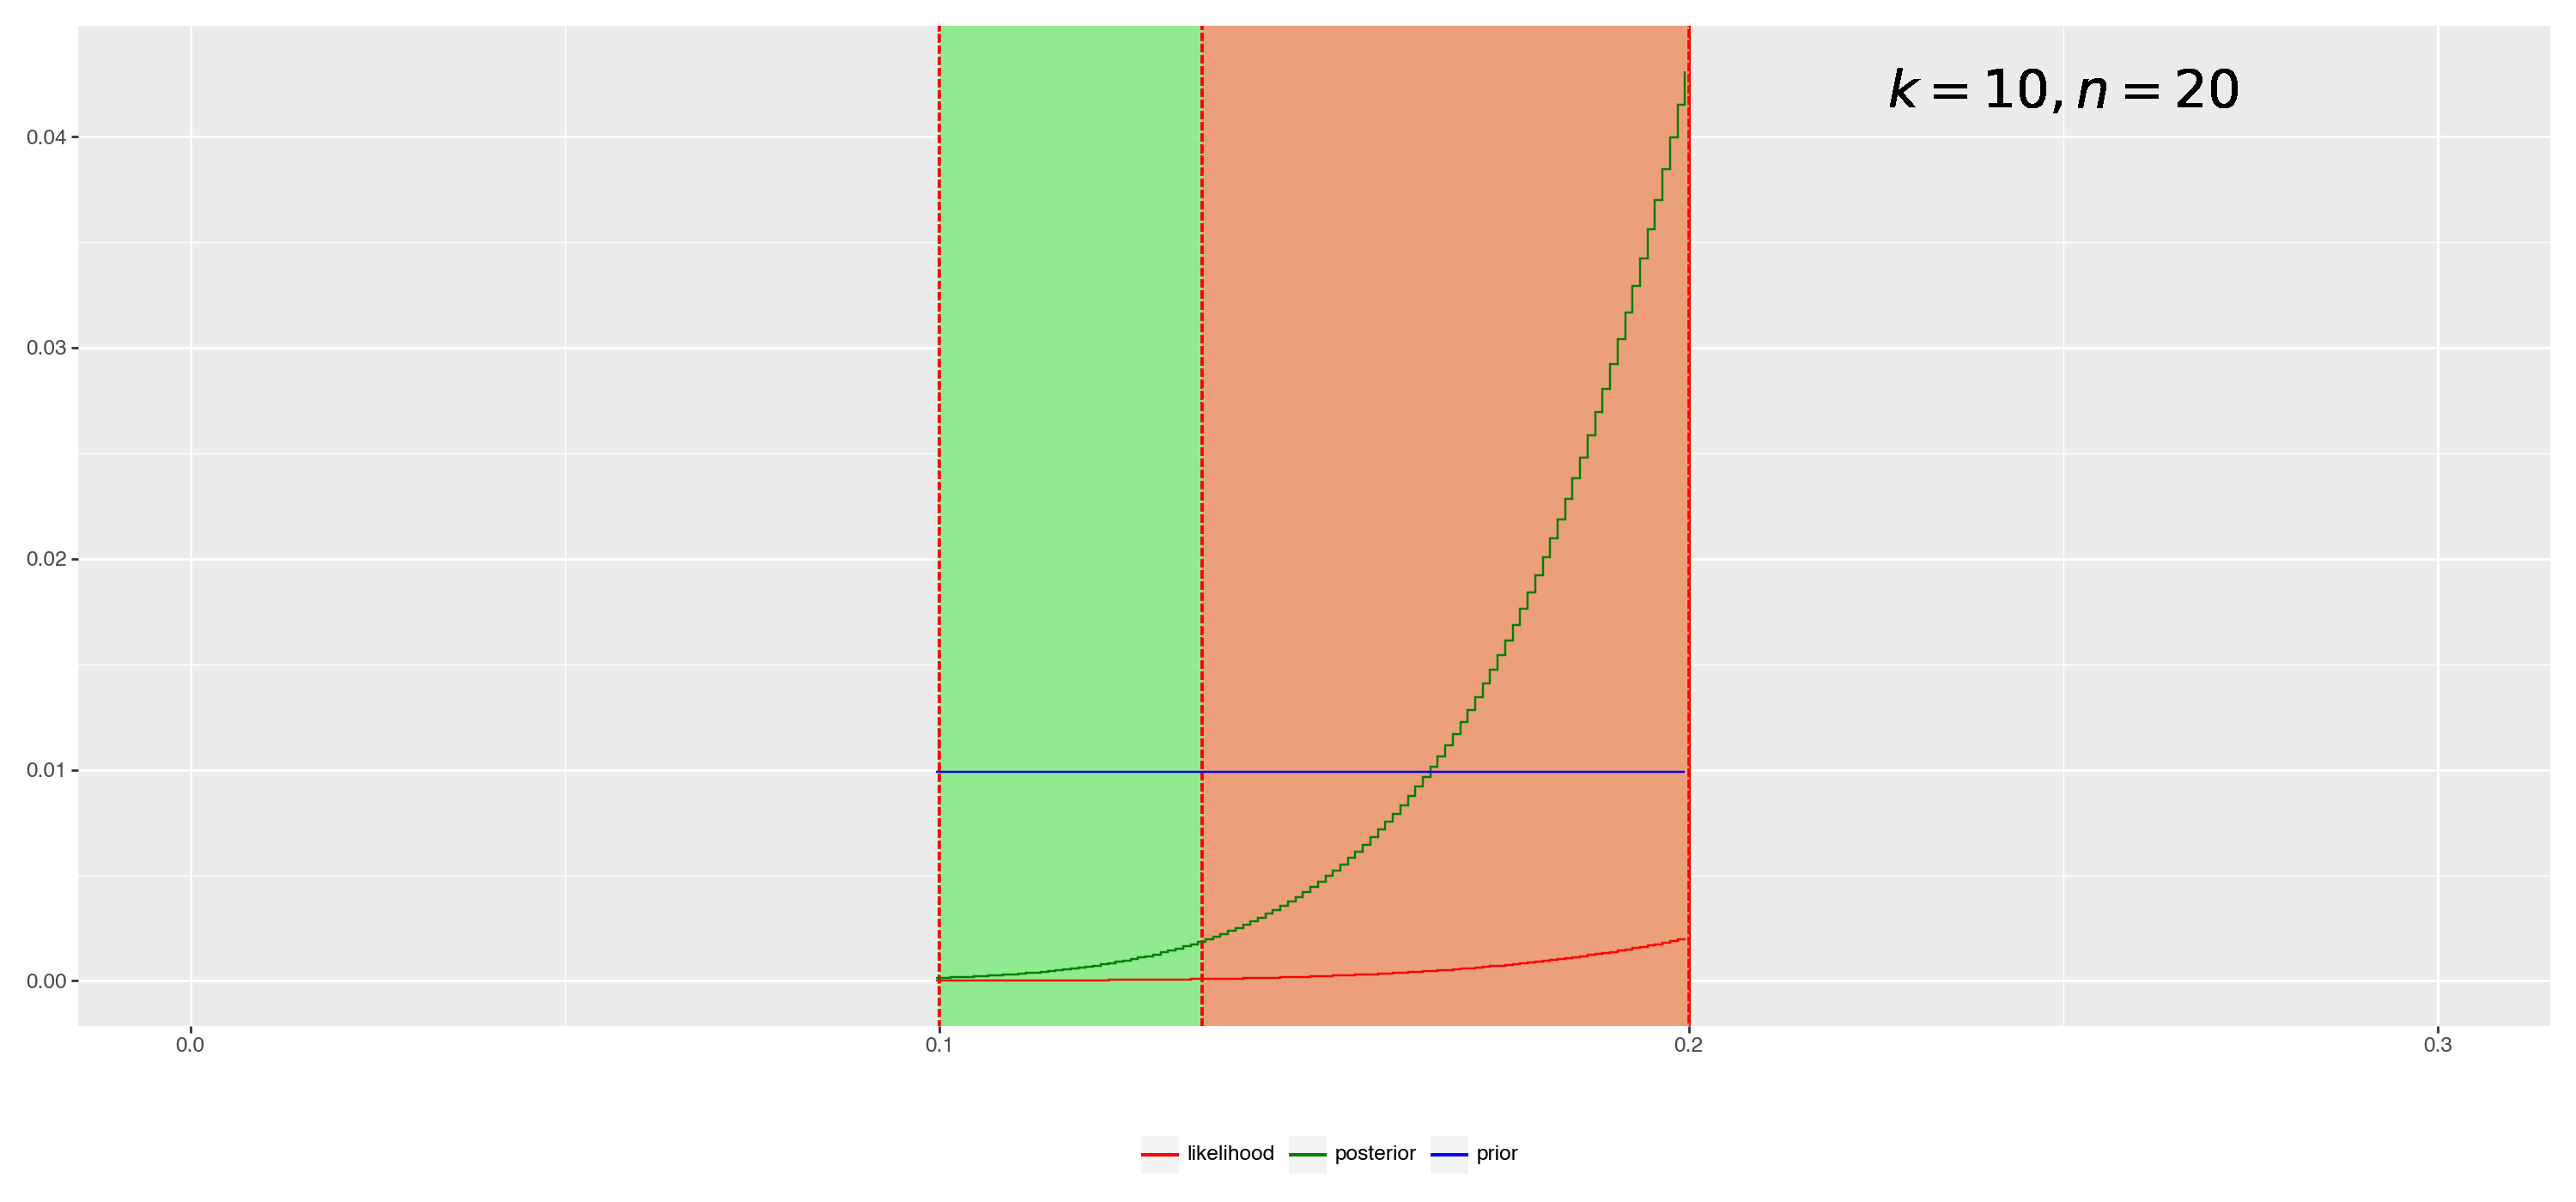

In [15]:
options.figure_size = (15, 7)
p = ggplot(df)
p = p + geom_rect(xmin=0.1, xmax=0.2, ymin=-5, ymax=5.0, 
                  fill = 'lightgreen', color = 'red', alpha =0.1, linetype='--')
p = p + geom_rect(xmin = ci.loc[0, 'p'], xmax = ci.loc[1,'p'], ymin=-0.5, ymax=5.0, 
                  fill = 'lightsalmon', color = 'red', alpha =0.05, linetype='--')
p = p + geom_step(aes(x = 'p1', y = 'value', color = 'function'))
p = p + scale_x_continuous(name = '', limits=(0,0.3)) + scale_y_continuous(name = '')
p = p + theme(legend_position="bottom")
p = p + scale_color_manual(name = ' ', values = ['red', 'green', 'blue'])
p = p + geom_text(x=0.25, y=0.042, label =r'$k=10, n=20$', size=22)
display(p)
# p.save('informed_posterior.pdf', path='results', height=6, width=12, verbose=False)

# Homework

## 6.1 Paradox of confidence intervals* (<font color='red'>1p</font>) 

The figure showing the mismatch between the confidence interval and the region of parameter values gives a paradoxical impression that for most observations, the confidence interval is way off from the region of plausible parameter values. This plot does not show how rare or frequent the possible outcomes are. Augment the figure with a horizontal barplot that shows the probability of $k$ values for the true parameter value $p=0.15$. Color in blue the bars where the confidence interval contains $0.015$, the remaining ones color in red. Intepret the results.

**Hint:** `plotnine` is not designed to draw such graphs but you can cheat. Create probability data in one data frame and confidence interval data in another data frame. Then add an extra column `facet` and set it to `frequency` for the probability data and `confidence intervals` for the interval data, and concatenate the data frames. Now draw both visualisations using the `facet` attribute. As a result, the graphs should occur only in desired facets. 

## 6.2 Beta distribution as a limit* (<font color='red'>1p</font>)

All figures above are drawn using a finite grid for defining the uninformative prior distribution. Show visually that corresponding posterior distributions converge to a single continuous beta distribution. 
For that, look at three settings $k\in\{5, 10, 15\}$ for $n=20$ and consider priors with grid step $\Delta p\in\{0.1, 0.01, 0.001, 0.0001\}$. Draw the corresponding density plots together with an appropriate beta distribution.
It is quite likely that the results do not match at the first attempt. Explain what you forgot the first time. 

In [15]:
%config IPCompleter.greedy=True